<a href="https://colab.research.google.com/github/NehadMousa/BrandeisUniversity-MS3/blob/main/GOOGLENET_pytorch_vision_googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is optionally accelerated with a GPU runtime.
### If you would like to use this acceleration, please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# GoogLeNet

*Author: Pytorch Team*

**GoogLeNet was based on a deep convolutional neural network architecture codenamed "Inception" which won ImageNet 2014.**
<!-- 
_ | _
- | -
![alt](https://pytorch.org/assets/images/googlenet1.png) | ![alt](https://pytorch.org/assets/images/googlenet2.png) -->

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# required import
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image as im
import os
import torchvision.models as models
from torchvision import datasets, models, transforms
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time

**Load Data into Custom Dataset and create Dataloader** of batches(Batch_Size)

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from PIL import Image as im
import matplotlib.pyplot as plt

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None , affine_transfomer =None):
        self.img_labels = pd.read_csv(annotations_file, sep='\t', header=None)
        print(f'self.img_labels: {self.img_labels.shape}')
        self.img_dir = img_dir
        self.affine_transfomer = affine_transfomer
        if transform == None:
          transform = transforms.Compose([
                      # transforms.Resize(224),
                      transforms.ToTensor(),
                      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                      ])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # image = read_image(img_path)
        # print(img_path)
        #remove convert to RGB
        image = im.open(img_path).resize((224,224)).convert('RGB')
        label = self.img_labels.iloc[idx, 1]
        if self.affine_transfomer:
          image = self.affine_transfomer(image)
        if self.transform:
          image = self.transform(image)
        if self.target_transform:
          label = self.target_transform(label)
        return image, label


In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


## Train Function Starts Here 

In [ ]:

learning_rate = .0001
momentum=0.5
model_name = "googlenet"
# Number of classes in the dataset
num_classes = 11
# Batch size for training (change depending on how much memory you have)
batch_size = 100
# Number of epochs to train for
num_epochs = 21

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define GoogleNet model ################################################
# setup googlenet model and override the output layer to return 10 classes instead
# model = torch.hub.load('pytorch/vision:v0.10.0', model_name, pretrained=True)
model = models.googlenet(pretrained=False)
# overrides the output layer
model.fc = nn.Linear(in_features=1024 , out_features=num_classes , bias=True)
# # Detect if we have a GPU available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# # move the input and model to GPU for speed if available
model = model.to(device)


# load data into data loader ###########################################
training_path= '/content/drive/MyDrive/MS3/AI Final Project 05-2022/training'
train_data = []
# increase size of train data 
# for i in range(4):
training_data = CustomImageDataset(
    annotations_file=f'{training_path}/labels.txt',
    img_dir=training_path
)
train_data.append(training_data)
affine_transfomer = transforms.RandomAffine(degrees=(20, 30), translate=(0.1, 0.3), scale=(1 / 255, 2/255))
training_data = CustomImageDataset(
    annotations_file=f'{training_path}/labels.txt',
    img_dir=training_path
    ,affine_transfomer=affine_transfomer
)
train_data.append(training_data)
# training_data = CustomImageDataset(
#     annotations_file=f'{training_path}/labels.txt',
#     img_dir=training_path
#     ,affine_transfomer=affine_transfomer
# )
# train_data.append(training_data)
training_data = torch.utils.data.ConcatDataset(train_data)
print(len(training_data))


train_size = int(0.9 * len(training_data))
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

print(f'Train Dataloader: {len(train_dataset)} - val_dataloader: {len(val_dataset)}')
# end of load data into data loader ###########################################

###########################################

# Reset the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum= momentum)


/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:50: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


self.img_labels: (860, 2)
self.img_labels: (860, 2)
1720
Train Dataloader: 1548 - val_dataloader: 172


**Main Executrion Starts Here **

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()

# train model
def train(model, training_loader, mode='Training'):
    # Set the model to training mode
    running_loss = 0.
    epoch_acc = 0.0
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # data = data.to(device)
        # Every data instance is an input + label pair
        inputs, labels = data
        print(f'iteration: {i} of input: {inputs.shape} labels: {labels.shape} ')
        # labels = labels -1
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # Make predictions for this batch
        outputs = model(inputs)
        
        # Required only for GoogleNet, to get GoogleNet output propabilities
        if mode == 'Training':
          outputs = outputs[0]

        print(f'iteration: {i}  labels: {labels.shape} - Output: {outputs.shape}')
        # print(f'iteration: {i} labels: {labels}')
        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()
        # Gather data and report
        running_loss += loss.item()
        data_acc = accuracy(outputs, labels)
        epoch_acc += data_acc
        print(f'iteration: {i} - Loss: {running_loss} - Accuracy: {data_acc}')

    epoch_acc = epoch_acc / len(training_loader)
    return running_loss , epoch_acc


**Model Training **

In [ ]:
def train_model(model , training_loader, num_epochs , mode='Training'):
  since = time.time()
  acc_history = []
  loss_history = []
  best_acc = 0.0
  max_loss = 0
  # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum= momentum
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    running_loss , epoch_acc = train(model , training_loader , mode)
    if epoch_acc > best_acc:
      best_acc = epoch_acc
    acc_history.append(epoch_acc)
    loss_history.append(running_loss)
    
  time_elapsed = time.time() - since
  print(mode)
  print('complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))
  print(f'latest running_loss {running_loss} - loss History: {loss_history}')
  print('Best val Acc: {:4f}'.format(best_acc) , f'with MAX loss: {acc_history}')


# Main Training 

In [ ]:
model.train(True)
train_model(model , train_dataloader, num_epochs=num_epochs, mode='Training')
# Validation using the train set
# model.train(False)
model.eval()
train_model(model , val_dataloader, num_epochs= 1, mode='Validation')

Epoch 0/20
iteration: 0 of input: torch.Size([100, 3, 224, 224]) labels: torch.Size([100]) 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


iteration: 0  labels: torch.Size([100]) - Output: torch.Size([100, 11])
iteration: 0 - Loss: 1.1827830076217651 - Accuracy: 0.5699999928474426
iteration: 1 of input: torch.Size([100, 3, 224, 224]) labels: torch.Size([100]) 
iteration: 1  labels: torch.Size([100]) - Output: torch.Size([100, 11])
iteration: 1 - Loss: 2.157323658466339 - Accuracy: 0.6299999952316284
iteration: 2 of input: torch.Size([100, 3, 224, 224]) labels: torch.Size([100]) 
iteration: 2  labels: torch.Size([100]) - Output: torch.Size([100, 11])
iteration: 2 - Loss: 3.366880714893341 - Accuracy: 0.5099999904632568
iteration: 3 of input: torch.Size([100, 3, 224, 224]) labels: torch.Size([100]) 
iteration: 3  labels: torch.Size([100]) - Output: torch.Size([100, 11])
iteration: 3 - Loss: 4.599138915538788 - Accuracy: 0.5199999809265137
iteration: 4 of input: torch.Size([100, 3, 224, 224]) labels: torch.Size([100]) 
iteration: 4  labels: torch.Size([100]) - Output: torch.Size([100, 11])
iteration: 4 - Loss: 5.775435626506

# Save Model

In [ ]:
# Save and load the model
rootPath = '/content/drive/MyDrive/MS3/AI Final Project 05-2022'
save_to_path = f'{rootPath}/googlenet-model.pth'
torch.save(model , save_to_path)


# Load Model and Test Data

In [ ]:
class TestDataset(Dataset):
  def __init__(self, img_dir):
      self.img_dir = img_dir
      self.test_files = os.listdir(self.img_dir)
      print(f'self.test_files length: {len(self.test_files)}')
      
      self.transform = transforms.Compose([
                  transforms.ToTensor()
                  ])
      
  def __len__(self):
      return len(self.test_files)

  def __getitem__(self, idx):
      file_name = self.test_files[idx]
      img_path = os.path.join(self.img_dir, file_name)
      image = im.open(img_path).resize((224,224)).convert('RGB')
      label = 0
      if self.transform:
        image = self.transform(image)
      # if self.target_transform:
      #   label = self.target_transform(label)
      return image, label , file_name

def test(model, test_loader):
  # Set the model to training mode
  model.eval()
  outputs_data = []
  for i, data in enumerate(test_loader):
    inputs, labels , file_names = data
    print(f'iteration: {i} of input: {inputs.shape} labels: {labels.shape} ')
    # Make predictions for this batch
    outputs = model(inputs)
    
    # Required only for GoogleNet, to get GoogleNet output propabilities
    # outputs = outputs[0]

    _, preds = torch.max(outputs, dim=1)

    file_names = list(file_names)
    preds = preds.numpy()
    # print(list(file_names))
    # print(preds)
    for idx in range(len(preds)):
      outputs_data.append((file_names[idx] , preds[idx]))
      # print(file_names[idx] , preds[idx])
  return outputs_data



In [ ]:
def test_model(model, img_dir):
  test_data = TestDataset(img_dir)
  print(len(test_data))
  batch_size = len(test_data)
  test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
  return test(model , test_dataloader)

# load model 
rootPath = '/content/drive/MyDrive'
save_to_path = f'{rootPath}/model.pth'
model = torch.load(save_to_path)


testing_path= '/content/drive/MyDrive/test_nol'
outputs_data = test_model(model, testing_path)
df = pd.DataFrame.from_records(outputs_data, columns =['File_Name', 'Label'])
rootPath = '/content/drive/MyDrive/'
df.to_csv(f'{rootPath}/googlenet-results.csv')
print(df.head(10))


self.test_files length: 200
200
iteration: 0 of input: torch.Size([200, 3, 224, 224]) labels: torch.Size([200]) 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


  File_Name  Label
0  0061.png      1
1  0052.png      2
2  0057.png      7
3  0058.png      8
4  0060.png     10
5  0053.png      4
6  0059.png      9
7  0056.png      6
8  0055.png      5
9  0054.png      4


# Read and show loss vs accuracy

        loss  accuracy
0   1.182783      0.57
1   2.157324      0.63
2   3.366881      0.51
3   4.599139      0.52
4   5.775436      0.53
5   6.894623      0.55
6   8.010722      0.56
7   9.259353      0.53
8  10.459617      0.51
9  11.532814      0.58
    n       loss  accuracy
0 NaN   1.323652      0.48
1 NaN   2.372198      0.56
2 NaN   3.472772      0.57
3 NaN   4.654993      0.55
4 NaN   5.811684      0.54
5 NaN   7.115074      0.51
6 NaN   8.231073      0.57
7 NaN   9.478753      0.53
8 NaN  10.737143      0.50
9 NaN  11.960617      0.49


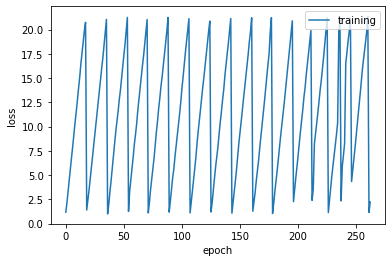

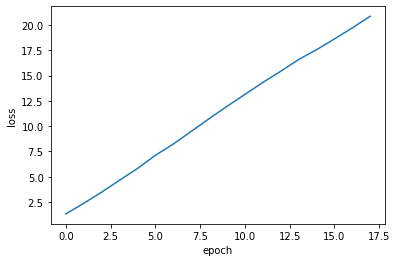

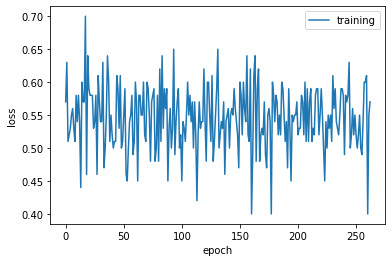

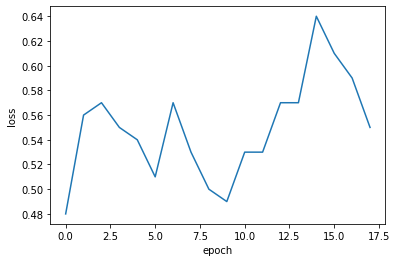

In [ ]:
loss_accuracy= '/content/drive/MyDrive/MS3/AI Final Project 05-2022/loss_accuracy_googlenet.csv'
df = pd.read_csv(loss_accuracy, sep=',', header=None,names=['loss' , 'accuracy'])
print(df.head(10))


loss_accuracy= '/content/drive/MyDrive/MS3/AI Final Project 05-2022/loss_accuracy_googlenet_validation.csv'
val_df = pd.read_csv(loss_accuracy, sep=',', header=None,names=['n', 'loss' , 'accuracy'], index_col=False)
val_df.reset_index()
print(val_df.head(10))

epoch_nums = df.index
training_loss = df['loss']

val_epoch_nums = val_df.index
val_loss = val_df['loss']

plt.plot(epoch_nums, training_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

plt.plot(val_epoch_nums, val_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

epoch_nums = df.index
training_accuracy = df['accuracy']

val_epoch_nums = val_df.index
val_accuracy = val_df['accuracy']

plt.plot(epoch_nums, training_accuracy)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

plt.plot(val_epoch_nums, val_accuracy)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()